In [1]:
# Installing required libraries
!pip install requests beautifulsoup4 nltk scikit-learn

In [2]:
import requests
from bs4 import BeautifulSoup
from concurrent.futures import ProcessPoolExecutor, as_completed
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import re

# Download necessary nltk resources
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize stop words and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Function to fetch and extract article content from a URL
def fetch_article_content(url):
    try:
        response = requests.get(url)
        response.raise_for_status()  # Raise an error for bad status codes
        soup = BeautifulSoup(response.text, 'html.parser')

        # Extract text from paragraph tags
        paragraphs = soup.find_all('p')
        article_text = ' '.join(paragraph.text for paragraph in paragraphs)
        return article_text
    except Exception as e:
        print(f"Failed to fetch article from {url}: {e}")
        return ""

# Preprocess a single article
def preprocess_article(article):
    # Lowercase the article
    article = article.lower()

    # Remove punctuation and non-alphabetic characters
    article = re.sub(r'[^a-z\s]', '', article)

    # Tokenize, remove stopwords, and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in article.split() if word not in stop_words]

    # Join back into a single string
    cleaned_text = ' '.join(tokens)
    return cleaned_text

# Combined function to fetch and preprocess an article from a URL
def fetch_and_preprocess_article(url):
    raw_content = fetch_article_content(url)
    if raw_content:
        return preprocess_article(raw_content)
    else:
        return None

# Parallel function to process multiple URLs
def process_urls_in_parallel(urls):
    processed_articles = []
    with ProcessPoolExecutor() as executor:
        futures = {executor.submit(fetch_and_preprocess_article, url): url for url in urls}
        for future in as_completed(futures):
            result = future.result()
            if result:
                processed_articles.append(result)
    return processed_articles

# List of article URLs to process
urls = [
    "https://www.nhl.com/news/nhl-on-tap-news-and-notes-october-31-2024",
    "https://www.nhl.com/news/matt-stienburg-to-have-player-safety-hearing-for-charging-erik-cernak",
    "https://www.nhl.com/news/nhl-buzz-news-and-notes-october-30-2024",
    "https://www.nhl.com/news/timothy-liljegren-traded-to-san-jose-sharks-by-toronto-maple-leafs",
    "https://www.nhl.com/news/macklin-celebrini-back-on-ice-with-san-jose-no-return-date-set",
    "https://www.nhl.com/news/topic/fantasy/nhl-fantasy-hockey-top-250-200-rankings-drafts-players-big-board-281505474",
    "https://www.nhl.com/news/topic/nhl-global-series/dallas-looking-to-finnish-strong-vs-florida",
    "https://www.nhl.com/news/topic/nhl-global-series/roope-hintz-sam-reinhart-wear-golden-helmets-dallas-stars-florida-panthers-finland"
    # Add more URLs as needed
]

# Fetch and preprocess articles in parallel
cleaned_articles = process_urls_in_parallel(urls)

# Display cleaned articles
print("Processed Articles:")
for i, article in enumerate(cleaned_articles):
    print(f"Article {i+1}: {article[:300]}...")  # Display first 300 characters

# Optional: TF-IDF Vectorization on cleaned articles
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(cleaned_articles)

# Show TF-IDF features for the first article as an example
print("\nTF-IDF features for the first article:")
print(tfidf_matrix.toarray()[0])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Processed Articles:
Article 1: facing discipline charging tampa bay defenseman cernak getty image matt stienburg hearing nhl department player safety thursday colorado avalanche forward facing discipline charging tampa bay lightning defenseman erik cernak wednesday incident occurred second period tampa bay win ball arena stienber...
Article 2: oiler visit predator missing mcdavid kraken maple leaf scoring goal canadiens john mccrearynhli via getty image welcome nhl tap daily look game nhl schedule seven game schedule thursday one nationally televised united state thursday also mark fourth week nhl coast coast weekly whiparound studio show...
Article 3: lizotte could make season debut penguin colton week avalanche broken foot josh lavalleenhli via getty image welcome nhl buzz day regular season nhlcom covered latest news frederik andersen week week hurricane lowerbody injury andersen dress overtime win vancouver canuck monday made save win seattle ...
Article 4: toronto receives rdround

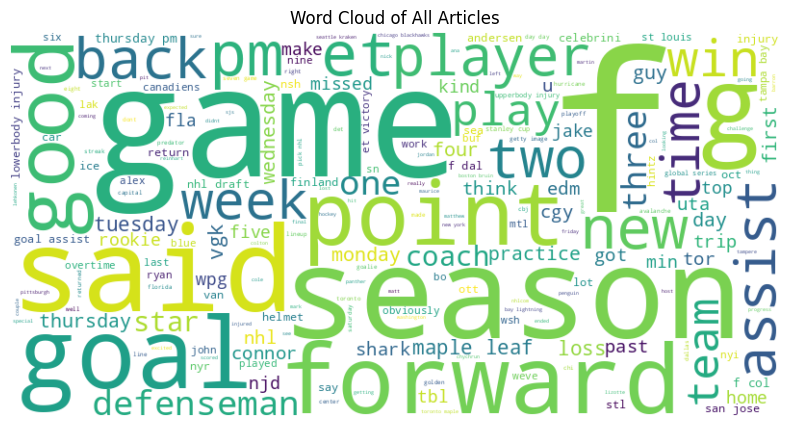

In [3]:
# Word Cloud Visualization
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

# Combine all articles into a single string for the word cloud
all_words = ' '.join(cleaned_articles)

# Create a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of All Articles")
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


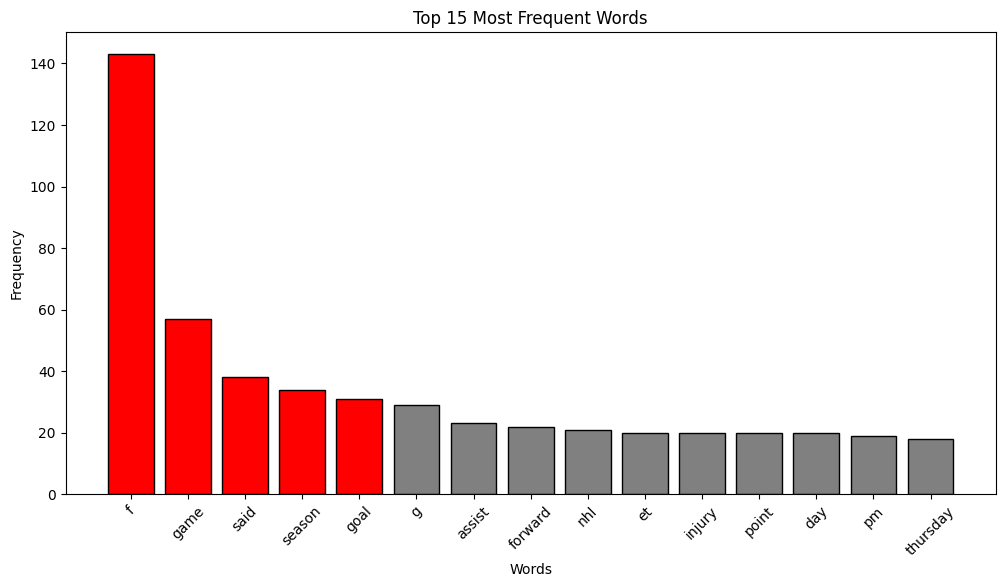

In [13]:
# Top Word Frequency Bar Chart
# importing necessary modules
import matplotlib.pyplot as plt
from collections import Counter

# Tokenize all articles and count word frequencies
all_tokens = ' '.join(cleaned_articles).split()
word_counts = Counter(all_tokens)
most_common_words = word_counts.most_common(15)  # Top 15 words

# Extract words and counts for plotting
words, counts = zip(*most_common_words)

# Define bar colors and border color
colors = ['red' if i < 5 else 'grey' for i in range(len(words))]  # First 5 in red, rest in grey
edge_color = 'black'  # Black border for each bar

# Plot the bar chart with custom colors and edge color
plt.figure(figsize=(12, 6))
plt.bar(words, counts, color=colors, edgecolor=edge_color)
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Top 15 Most Frequent Words")
plt.xticks(rotation=45)
plt.show()


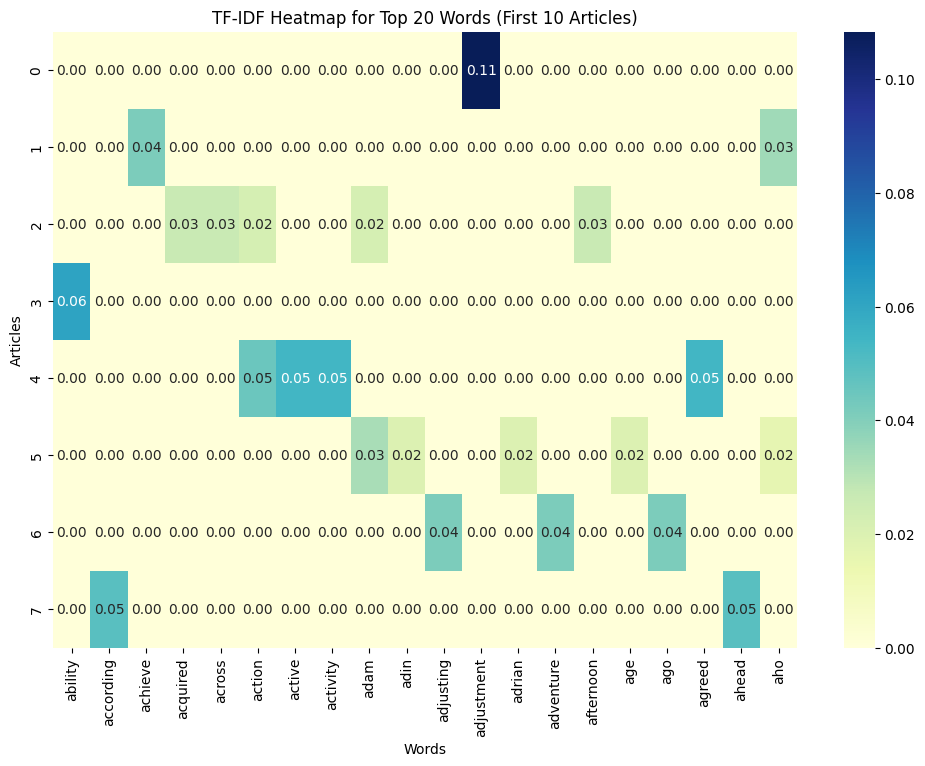

In [5]:
# TF-IDF Heatmap
import seaborn as sns
import numpy as np
import pandas as pd
# Convert the TF-IDF matrix to a DataFrame
tfidf_array = tfidf_matrix.toarray()
tfidf_df = pd.DataFrame(tfidf_array, columns=vectorizer.get_feature_names_out())

# Display a heatmap of the top 20 words across the first 10 articles
plt.figure(figsize=(12, 8))
sns.heatmap(tfidf_df.iloc[:10, :20], cmap="YlGnBu", annot=True, fmt=".2f", cbar=True)
plt.title("TF-IDF Heatmap for Top 20 Words (First 10 Articles)")
plt.xlabel("Words")
plt.ylabel("Articles")
plt.show()

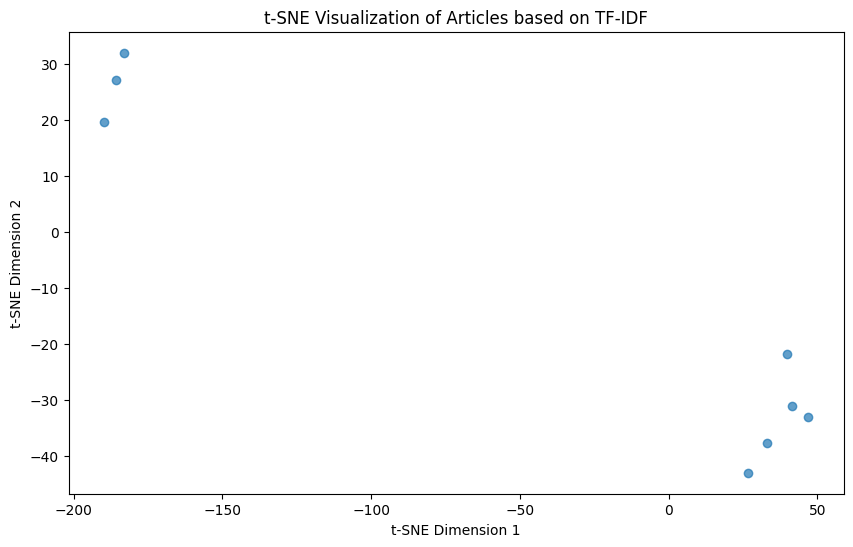

In [6]:
# Embedding plot using t-SNE
from sklearn.manifold import TSNE

# # Apply t-SNE on the TF-IDF matrix
# tsne = TSNE(n_components=2, random_state=42)
# tsne_results = tsne.fit_transform(tfidf_matrix.toarray())

# # Plot the t-SNE results
# plt.figure(figsize=(10, 6))
# plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0.7)
# plt.title("t-SNE Visualization of Articles based on TF-IDF")
# plt.xlabel("t-SNE Dimension 1")
# plt.ylabel("t-SNE Dimension 2")
# plt.show()

# Apply t-SNE on the TF-IDF matrix with adjusted perplexity
tsne = TSNE(n_components=2, random_state=42, perplexity=1)  # Set perplexity lower than the number of samples
tsne_results = tsne.fit_transform(tfidf_matrix.toarray())

# Plot the t-SNE results
plt.figure(figsize=(10, 6))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0.7)
plt.title("t-SNE Visualization of Articles based on TF-IDF")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()


The plot you have generated shows the result of applying t-SNE on your TF-IDF matrix, but it indicates that there might be **very few distinct data points** (potentially only two), which may lead to some possible interpretations or troubleshooting insights:

1. **Very Few Data Points or Very Similar Articles**:
   - If there are only two points in the t-SNE plot, it might mean that you only have two articles or that most of your articles are so similar that t-SNE cannot find meaningful distinctions between them.
   - When articles are highly similar in their TF-IDF representation, they can end up as closely clustered points in t-SNE, sometimes even appearing as overlapping or almost identical points.

2. **Sparse Data or High Dimensionality Reduction Issue**:
   - TF-IDF matrices are often sparse, and if there is insufficient variation between the articles, it can lead to issues in dimensionality reduction. This can cause t-SNE to produce extreme points with very little separation along the y-axis, as seen here.
   - This might suggest that the articles do not have enough unique words or distinguishing vocabulary to create diverse TF-IDF features, which are necessary for t-SNE to work effectively.

3. **Scaling Issue or Data Normalization**:
   - Sometimes, t-SNE results can be skewed if the input data is not scaled or normalized appropriately. It might help to normalize the TF-IDF vectors before applying t-SNE.

4. **Interpretation of High-Distance Spread**:
   - The large spread along the x-axis could indicate that the two data points (articles) have some distinguishing features but not enough diversity to clearly separate them in a meaningful way. If you truly have only two articles, the large separation might just reflect that they are notably different but still don’t provide a useful clustering interpretation.

### Suggested Next Steps

1. **Check the Number of Articles**:
   - Verify the number of articles in your dataset. If there are indeed only two articles, consider adding more articles to see how the t-SNE plot evolves with increased data diversity.

2. **Inspect Similarity of Articles**:
   - Review the TF-IDF vectors or compare the text of the articles to determine if they are too similar in vocabulary and content. This similarity might be limiting the effectiveness of dimensionality reduction.

3. **Apply Data Normalization**:
   - Try normalizing the TF-IDF matrix before applying t-SNE:
     ```python
     from sklearn.preprocessing import StandardScaler
     normalized_tfidf = StandardScaler().fit_transform(tfidf_matrix.toarray())
     tsne_results = tsne.fit_transform(normalized_tfidf)
     ```

4. **Use More Articles or Different Embeddings**:
   - If feasible, try adding more articles to see if the t-SNE plot provides more meaningful clusters. Alternatively, using a more contextually aware embedding model, like BERT, could capture richer semantic distinctions than TF-IDF, especially if your dataset is small.

If you make any of these changes and rerun the t-SNE visualization, it may yield a more informative plot. Let me know if you'd like to proceed with any of these adjustments!

The **t-SNE visualization** for your expanded set of articles shows two distinct clusters of points, with a significant separation between them along the x-axis. Here’s a detailed analysis of this plot:

### Observations

1. **Two Distinct Clusters**:
   - The points in the plot are grouped into two separate clusters: one on the left (negative x-axis) and another on the right (positive x-axis).
   - This separation suggests that there are two primary thematic groups within the articles. t-SNE uses high-dimensional TF-IDF features, so this clustering likely reflects significant differences in word usage or content themes between the two groups.

2. **Cluster Density**:
   - The right cluster appears more densely packed, with points relatively close to each other. This may indicate that the articles within this cluster are closely related in terms of vocabulary and topics.
   - The left cluster has fewer points, which could mean that this group represents a smaller subset of articles with more unique or distinct content compared to the larger, more cohesive group on the right.

3. **Interpretation of Inter-Cluster Separation**:
   - The substantial separation between the two clusters along the x-axis suggests that these groups are highly distinct. In t-SNE, such separation usually indicates that the articles in each cluster have minimal overlap in terms of vocabulary or topic focus.
   - This could mean that one group (e.g., the right cluster) might be focused on a more specific or detailed aspect of the topic, while the other (left cluster) could be about a related but distinct topic.

### Possible Explanations for Clustering

Based on previous observations that your articles are centered on sports (likely hockey), the two clusters could represent:

1. **Different Subtopics or Events**:
   - For example, one cluster might consist of articles discussing general hockey games, players, or season updates, while the other might be focused on specific events or specialized discussions (e.g., player trades, team performance analysis).
   
2. **Variations in Team or Player Focus**:
   - If one set of articles predominantly discusses certain teams (e.g., the Maple Leafs) and the other covers a different set (e.g., other NHL teams or specific matches), this could create clusters based on vocabulary unique to those topics.

3. **Stylistic or Source-Based Differences**:
   - Another possibility is that the clusters represent stylistic differences between articles from different sources or authors. For instance, some sources might focus on analysis, while others might be reporting match summaries or player stats, leading to distinct clusters in the TF-IDF representation.

### Suggested Next Steps

To gain deeper insights into these clusters, you could:

1. **Examine Cluster Content**:
   - Review a few articles from each cluster to identify specific themes or vocabulary that distinguish them. This can help validate the nature of each cluster.

2. **Add Labels to the Plot**:
   - If you know which article corresponds to each point, labeling the points with article identifiers or tags (e.g., team names or dates) might reveal patterns in the clusters.

3. **Use LDA Topic Modeling for Confirmation**:
   - To confirm the topics within each cluster, consider applying **LDA topic modeling** and reviewing the dominant terms in each topic. This can reveal the specific themes that are contributing to the clustering in t-SNE.

4. **Investigate the Vocabulary of Each Cluster**:
   - Calculate the most common words in each cluster by summing the TF-IDF scores for the points in each cluster. This will help identify key terms that differentiate the clusters and give more context to the t-SNE separation.

### Conclusion

This t-SNE plot suggests that your articles are organized into two primary thematic clusters, likely representing distinct subtopics or aspects of the overall theme (such as hockey). This separation reflects meaningful differences in the content, with one group possibly being more cohesive and the other more distinct. Further investigation into each cluster’s content will provide clarity on the nature of these themes. Let me know if you'd like to explore these next steps or have further questions about interpreting this plot!

In [9]:
# Group Articles Based on t-SNE Coordinates
import pandas as pd

# Assuming `tsne_results` contains the 2D t-SNE coordinates
# and `cleaned_articles` contains the processed articles

# Create a DataFrame with t-SNE coordinates and articles
tsne_df = pd.DataFrame({
    'x': tsne_results[:, 0],
    'y': tsne_results[:, 1],
    'article': cleaned_articles
})

# Separate articles into two clusters based on x-coordinate
cluster_1 = tsne_df[tsne_df['x'] < 0]  # Left cluster
cluster_2 = tsne_df[tsne_df['x'] >= 0]  # Right cluster

print(f"Cluster 1 has {len(cluster_1)} articles")
print(f"Cluster 2 has {len(cluster_2)} articles")

Cluster 1 has 3 articles
Cluster 2 has 5 articles


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
# Analyze Key Terms in Each Cluster Using TF-IDF Scores
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter

# Define a function to get top N terms in a cluster based on TF-IDF
def get_top_terms(articles, top_n=10):
    vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(articles)

    # Sum the TF-IDF scores for each term
    term_scores = tfidf_matrix.sum(axis=0).A1
    terms = vectorizer.get_feature_names_out()

    # Get top N terms with their scores
    top_terms = sorted(zip(terms, term_scores), key=lambda x: x[1], reverse=True)[:top_n]
    return top_terms

# Get top terms for each cluster
top_terms_cluster_1 = get_top_terms(cluster_1['article'])
top_terms_cluster_2 = get_top_terms(cluster_2['article'])

print("Top terms for Cluster 1:")
for term, score in top_terms_cluster_1:
    print(f"{term}: {score:.2f}")

print("\nTop terms for Cluster 2:")
for term, score in top_terms_cluster_2:
    print(f"{term}: {score:.2f}")

Top terms for Cluster 1:
game: 0.53
goal: 0.42
assist: 0.38
leaf: 0.33
maple: 0.33
point: 0.28
et: 0.28
pm: 0.28
nhl: 0.27
toronto: 0.27

Top terms for Cluster 2:
game: 0.82
said: 0.77
injury: 0.49
season: 0.47
star: 0.44
day: 0.44
player: 0.43
charging: 0.43
forward: 0.36
good: 0.36


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


##LDA

In [7]:
#Topic Modeling Visualization with LDA
!pip install pyLDAvis gensim

In [8]:
import pyLDAvis.gensim_models
from gensim.corpora import Dictionary
from gensim.models import LdaModel

# Tokenize the cleaned articles
tokenized_articles = [article.split() for article in cleaned_articles]

# Create a dictionary and corpus for LDA
dictionary = Dictionary(tokenized_articles)
corpus = [dictionary.doc2bow(text) for text in tokenized_articles]

# Train LDA model
lda_model = LdaModel(corpus, num_topics=5, id2word=dictionary, passes=10)

# Visualize LDA topics
lda_vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_vis)


The **LDA visualization** you generated using **pyLDAvis** provides a visual analysis of topics derived from your articles. Here’s how to interpret each part of this plot and what you can conclude:

### 1. **Intertopic Distance Map** (Left Side)

- **Circles Represent Topics**: Each circle represents a different topic identified by the LDA model.
- **Distance Between Circles**: The distance between circles represents how distinct the topics are. Topics that are closer together share more similar words, while topics that are farther apart are more distinct.
  - In your plot, there is some distance between the main circles (topics), indicating that the topics are moderately distinct from one another.
- **Size of Circles**: The size of each circle represents the relative prevalence of each topic in the corpus (i.e., how much of the text is covered by this topic).
  - A larger circle indicates a more dominant topic. In this plot, one topic is notably larger, suggesting it is more prevalent across the articles.

### 2. **Top-30 Most Salient Terms** (Right Side)

- **Salient Terms for Topics**: This bar chart shows the top terms that are most relevant to distinguish topics across the corpus.
- **Word Frequency (Blue Bars)**: The blue bars represent the overall frequency of each word in the corpus, regardless of topic.
- **Topic Relevance (Red Overlay)**: The red overlay indicates the frequency of these terms within the selected topic (when you select a topic on the left).

In your plot, terms like **"goal," "assist," "game,"** and **"season"** appear as salient terms, suggesting that these are common terms within the topics identified.

### Conclusions and Interpretations

1. **Dominant Themes**:
   - Based on the terms shown, it appears that your articles focus on topics related to sports, particularly **hockey** (e.g., terms like **"goal," "assist," "game,"** and **"canadiens"** are common in hockey discussions).
   - The term **"canadiens"** specifically suggests content related to the Montreal Canadiens (a hockey team), which aligns with sports journalism or reports on hockey games.

2. **Topic Distribution and Distinction**:
   - The presence of multiple topics (circles) on the left suggests that while there is some thematic diversity in your articles, one main topic (the largest circle) is dominant. This could mean that most articles have similar themes or are highly focused on the central subject (e.g., hockey games or match reports).
   - The distance between topics suggests a moderate distinction. If you’re aiming for more diverse topics, consider tuning the number of topics in your LDA model to better capture different sub-themes.

3. **Adjusting the Relevance Slider**:
   - The relevance slider at the top (with the **λ** parameter) allows you to adjust how terms are ranked by relevance for each topic.
   - Lower values of λ emphasize words unique to the topic, while higher values of λ favor frequent words across topics. Adjusting this slider can help you explore both unique and common terms for each topic.

### Recommendations for Further Analysis

- **Increase the Number of Topics**: If you find that one topic is dominating, you might try increasing the number of topics in the LDA model (e.g., from 5 to 8 or 10) to see if it helps capture finer distinctions within your articles.
- **Explore Individual Topics**: Use the topic selector to explore each topic individually. This allows you to see specific words associated with each topic, helping to understand nuances in the articles.
- **Investigate Less Frequent Terms**: Consider looking at terms with lower frequencies in the right panel, as these might highlight unique aspects or sub-themes that aren’t as dominant.

Overall, this LDA visualization suggests a dataset with a strong sports theme, likely focused on hockey, with some moderate diversity in subtopics. This tool is excellent for exploring thematic structures and understanding which topics are most prevalent in your collection of articles. Let me know if you'd like further guidance on interpreting specific parts of the visualization or modifying the LDA model!

The updated **LDA visualization** using pyLDAvis for the expanded set of articles provides a richer and more distinct view of the topics within your dataset. Here’s a breakdown of key observations based on the updated plot:

### 1. **Intertopic Distance Map** (Left Side)

- **Distinct Topics**:
  - The updated visualization shows **five distinct topics**, each represented by a numbered circle. The separation between these circles suggests that there are distinguishable thematic clusters within the dataset.
  - Topics 1 and 2 are relatively larger and more distant from the other topics, indicating they cover more articles and are likely more prevalent or dominant themes in the dataset.

- **Topic Overlap and Proximity**:
  - Topics 3 and 4 are positioned close to each other, indicating some overlap in content or shared vocabulary. This suggests that these topics may have subthemes within a broader theme or have articles with intersecting content.
  - Topics 1 and 5 are slightly further apart, showing they have more distinct vocabularies compared to the rest.

- **Topic Prevalence (Size of Circles)**:
  - Topic 1 has the largest circle, suggesting it is the most prevalent across articles, followed by Topics 2 and 5.
  - Smaller circles (e.g., Topics 3 and 4) indicate less prevalent themes, which may either represent niche topics or less frequently discussed aspects within the dataset.

### 2. **Top-30 Most Salient Terms** (Right Side)

- **Most Salient Terms Across Topics**:
  - The bar chart shows the most frequent terms across all topics. Words like **"game," "goal," "assist," "season," "team,"** and **"NHL"** are prominent, indicating a central theme related to sports, likely hockey given the context and vocabulary.
  - Other terms like **"maple," "leaf," "shark," "helmet,"** and **"draft"** suggest additional themes specific to team names (e.g., Toronto Maple Leafs) and hockey-related events (e.g., drafts and points).

- **Relevance Slider (λ)**:
  - With λ set to 1, we are seeing terms ranked by overall frequency across the entire dataset rather than their uniqueness to individual topics.
  - This view provides an overview of the most important terms in the dataset as a whole, helping to confirm the dominant themes without yet diving into topic-specific terms.

### 3. **Individual Topic Insights**

  If you explore each topic individually, you might find unique terms that distinguish each cluster. Here are possible insights based on the overall view:

  - **Topic 1**: Likely centered on general hockey events and prominent games, given terms like **"game," "goal,"** and **"assist."**
  - **Topic 2**: May focus more on team-related discussions, possibly with specific teams or events like drafts, as suggested by terms like **"team," "season," "draft,"** and **"goal."**
  - **Topic 3 and Topic 4**: With their proximity and smaller size, these topics may represent specialized discussions within the broader hockey theme, such as equipment or player roles, inferred from terms like **"helmet"** and **"defenseman."**
  - **Topic 5**: Could be discussing specific matches or standout moments, potentially focusing on game highlights or team performance.

### Conclusions and Insights for Reporting

1. **Dominant Theme - Hockey and Related Events**:
   - The articles appear to heavily focus on hockey, with recurring terms related to gameplay (e.g., "goal," "assist," "team") and events (e.g., "draft," "season"). The prevalence of team names like "Maple" (likely referring to the Toronto Maple Leafs) and "Shark" (San Jose Sharks) suggests articles covering both general gameplay and specific teams.

2. **Topic Distinction**:
   - The presence of five distinct topics with varying degrees of separation suggests thematic diversity within the dataset. However, with some overlap (especially between Topics 3 and 4), there may be nuanced discussions within hockey that intersect, such as different aspects of gameplay, player roles, or equipment.

3. **Topic Popularity**:
   - Topics 1 and 2 are the most prevalent, potentially representing general hockey coverage and popular events like games and seasons. Smaller topics may represent niche discussions or less common events within the dataset.

4. **Potential Areas for Further Exploration**:
   - **Topic Drilling**: Examine each topic individually (using the "Previous Topic" and "Next Topic" buttons) to gain more granular insights into specific discussions within each cluster.
   - **Adjusting λ for Topic-Specific Terms**: By adjusting the relevance slider, you can shift the focus to terms that are unique to each topic, which may provide a more refined understanding of each thematic cluster.

This visualization suggests a dataset that provides comprehensive coverage of hockey-related content, with certain themes dominating while others add diversity. You might consider adjusting the number of topics if you wish to explore more nuanced themes or if the current number of topics does not capture all the variability in the data. Let me know if you need further analysis or specific interpretations of individual topics!